In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Phần 6: Chuẩn bị dữ liệu JSRT

## Bước 6.1: Gán nhãn từ jsrt_metadata.csv

In [3]:
import pandas as pd

# Đọc file metadata của JSRT
label_path = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/jsrt_metadata.csv'
df_jsrt = pd.read_csv(label_path)

# Cột 'study_id' đã có đuôi .png, dùng trực tiếp
df_jsrt['Image Index'] = df_jsrt['study_id']

# Gán nhãn: 1 nếu 'state' là malignant, ngược lại là 0 (benign hoặc no-nodule)
df_jsrt['Label'] = df_jsrt['state'].apply(lambda x: 1 if isinstance(x, str) and x.lower() == 'malignant' else 0)

# In thống kê
print('Số ảnh ung thư (label = 1):', df_jsrt[df_jsrt['Label'] == 1].shape[0])
print('Số ảnh không ung thư (label = 0):', df_jsrt[df_jsrt['Label'] == 0].shape[0])

✅ Số ảnh ung thư (label = 1): 100
✅ Số ảnh không ung thư (label = 0): 147


## Bước 6.2: Tiền xử lý ảnh

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

input_folder = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/images'
output_folder = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/processed_npy'
os.makedirs(output_folder, exist_ok=True)

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[LỖI] Không đọc được ảnh: {image_path}")
        return None
    img = cv2.equalizeHist(img)
    img = cv2.medianBlur(img, 3)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.stack([img, img, img], axis=-1)
    for i in range(3):
        img[:, :, i] = (img[:, :, i] - imagenet_mean[i]) / imagenet_std[i]
    return img.astype(np.float32)

# Tiền xử lý toàn bộ JSRT
for idx, row in tqdm(df_jsrt.iterrows(), total=len(df_jsrt), desc='Processing JSRT'):
    img_name = row['Image Index']
    img_path = os.path.join(input_folder, img_name)
    processed = preprocess_image(img_path)
    if processed is not None:
        save_name = img_name.replace('.png', '.npy')
        save_path = os.path.join(output_folder, save_name)
        np.save(save_path, processed)
print()
print("Đã lưu toàn bộ ảnh JSRT dưới dạng .npy")

Processing JSRT: 100%|██████████| 247/247 [04:18<00:00,  1.05s/it]


Đã lưu toàn bộ ảnh JSRT dưới dạng .npy


## Phần 6.3: Tính class weights để xử lý mất cân bằng

In [5]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=df_jsrt['Label'].values
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.8401360544217688), 1: np.float64(1.235)}


## Bước 3.2: Tạo custom generator đọc file .npy

In [6]:
import tensorflow as tf

class NPYDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, data_dir, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # ← Thêm dòng này
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            row = self.df.iloc[i]
            image_name = os.path.splitext(row['Image Index'])[0] + '.npy'
            image_path = os.path.join(self.data_dir, image_name)

            if not os.path.exists(image_path):
                print(f"[Cảnh báo] Thiếu file: {image_path} → Bỏ qua")
                continue

            image = np.load(image_path)
            label = row['Label']
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Phần 7: Huấn luyện Model B – từ đầu với JSRT

## Bước 7.1: Khởi tạo DenseNet121 từ ImageNet

In [7]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Bước 7.2: 10-fold Cross Validation - Chuẩn bị dữ liệu chia fold

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Danh sách kết quả từng fold
acc_list = []
sen_list = []
spe_list = []

# Tạo đối tượng k-fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = df_jsrt['Image Index'].values
y = df_jsrt['Label'].values

## Bước 7.3:

In [11]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}/3")

    train_df = df_jsrt.iloc[train_idx].reset_index(drop=True)
    val_df = df_jsrt.iloc[val_idx].reset_index(drop=True)

    train_gen = NPYDataGenerator(train_df, batch_size=32, data_dir='/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/processed_npy', shuffle=True)
    val_gen = NPYDataGenerator(val_df, batch_size=32, data_dir='/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/processed_npy', shuffle=False)

    model = build_model()
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        class_weight=class_weight_dict,
        verbose=1
    )

    # 🔍 Dự đoán trên tập validation
    y_true = val_df['Label'].values
    y_pred_prob = model.predict(val_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # 🎯 Tính Accuracy
    acc = accuracy_score(y_true, y_pred)
    acc_list.append(acc)

    # 🎯 Tính confusion matrix và các chỉ số khác
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        sensitivity = 0
        specificity = 0

    sen_list.append(sensitivity)
    spe_list.append(specificity)

    print(f"✅ Fold {fold+1} - Accuracy: {acc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")


🔁 Fold 1/3
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 317s 31s/step - accuracy: 0.6367 - loss: 0.7779 - val_accuracy: 0.5904 - val_loss: 1.3026
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.9084 - loss: 0.3303 - val_accuracy: 0.5904 - val_loss: 1.3241
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.9611 - loss: 0.2241 - val_accuracy: 0.5904 - val_loss: 1.3174
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.9947 - loss: 0.1021 - val_accuracy: 0.5904 - val_loss: 1.3584
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.9944 - loss: 0.0572 - val_accuracy: 0.5904 - val_loss: 1.4085
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 1.0000 - loss: 0.0292 - val_accuracy: 0.5904 - val_loss: 1.4857
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.9972 - loss: 0.0240 - val_accuracy: 0.5904 - val_loss: 1.4685
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 1.0000 - loss: 0.0220 - val_accuracy: 0.5904

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step
✅ Fold 3 - Accuracy: 0.5976, Sensitivity: 0.0000, Specificity: 1.0000


## Bước 7.4: Kết quả trung bình

In [12]:
print("\nTrung bình sau 3 folds:")
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_list), np.std(acc_list)))
print("Sensitivity: {:.4f} ± {:.4f}".format(np.mean(sen_list), np.std(sen_list)))
print("Specificity: {:.4f} ± {:.4f}".format(np.mean(spe_list), np.std(spe_list)))


Trung bình sau 3 folds:
Accuracy: 0.5952 ± 0.0034
Sensitivity: 0.0000 ± 0.0000
Specificity: 1.0000 ± 0.0000


## Bước 7.5: Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Bước 7.6: Đánh giá mô hình với Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


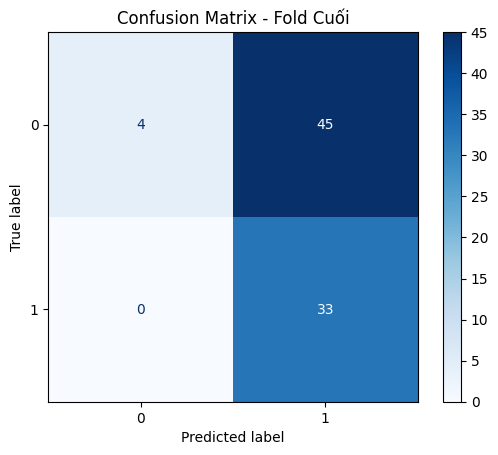

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Lấy nhãn thật từ val_df
y_true = val_df['Label'].values

# Dự đoán nhãn từ mô hình
pred_probs = model.predict(val_gen)
y_pred = (pred_probs > 0.5).astype(int).reshape(-1)

# Tạo và hiển thị confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Fold Cuối")
plt.show()

## Bước 7.7: Hiển thị hình ảnh bị phân loại sai

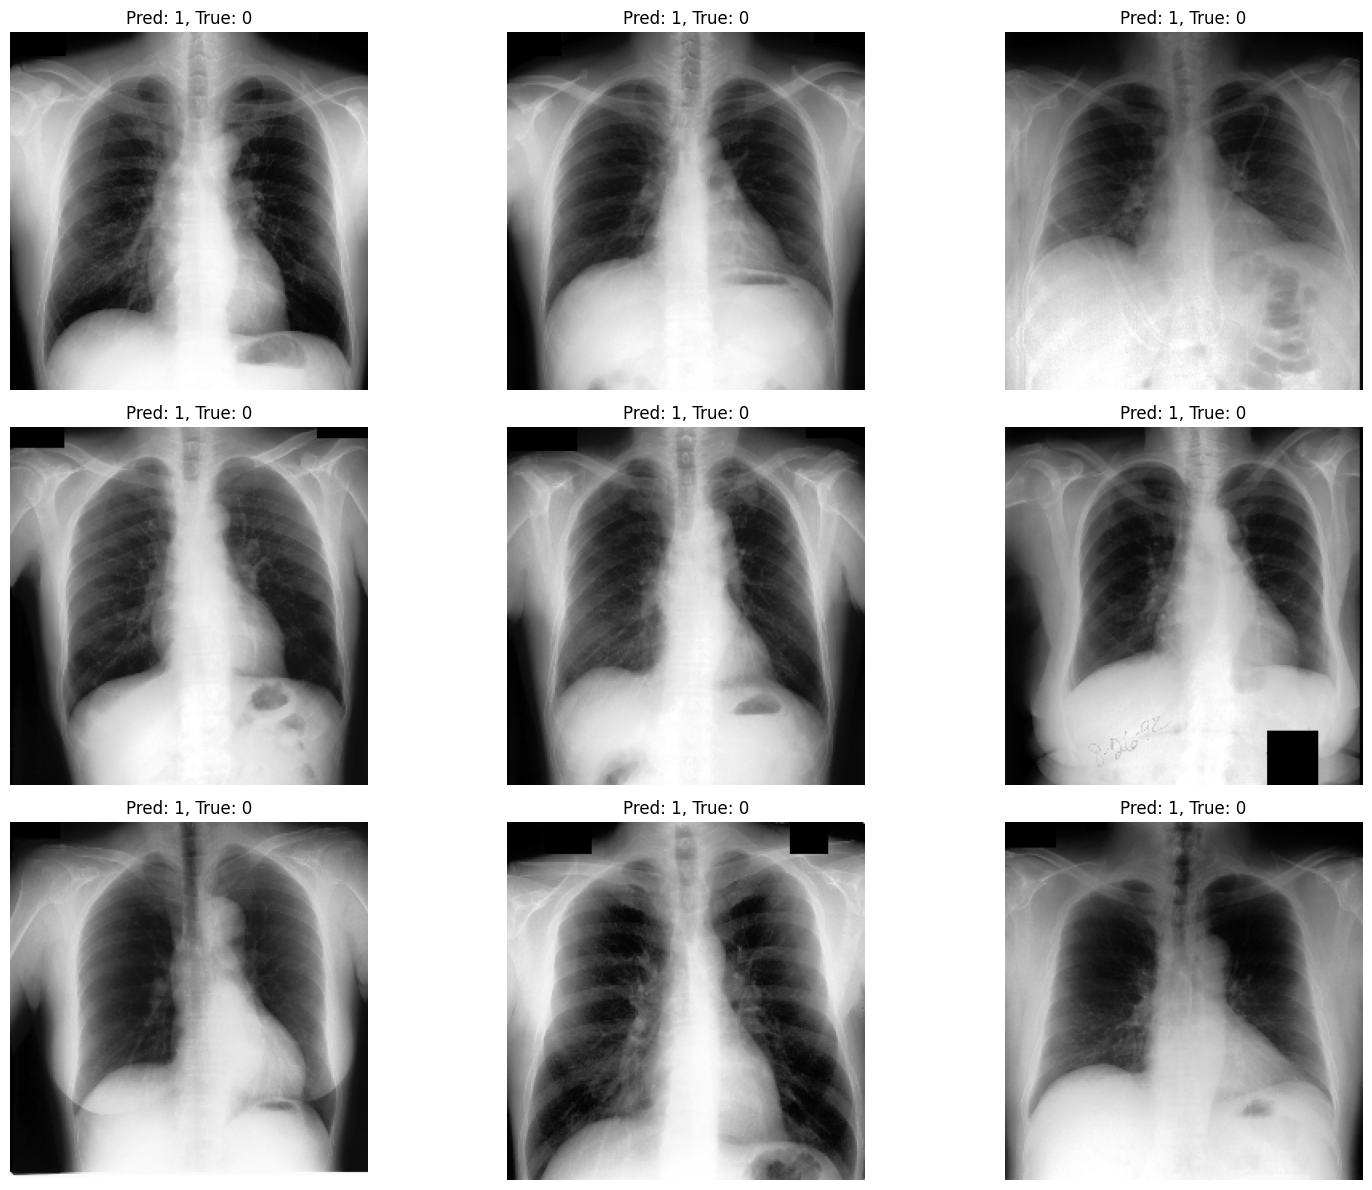

In [15]:
import os
import random

wrong_indices = np.where(y_true != y_pred)[0]
sample_wrong = random.sample(list(wrong_indices), min(9, len(wrong_indices)))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for idx, i in enumerate(sample_wrong):
    img_name = val_df.iloc[i]['Image Index']
    npy_path = os.path.join('/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/JSRT/processed_npy', img_name.replace('.png', '.npy'))
    img = np.load(npy_path)
    axes[idx].imshow(img[:, :, 0], cmap='gray')
    axes[idx].set_title(f"Pred: {y_pred[i]}, True: {y_true[i]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()